## <span style="color:green"> Notebook - Geophysical anomalies along a continental geotherm </span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

This notebook shows how to calculate a geotherm with conventional methods and calculate the associated conductivity and seismic velocity values. Geotherm here is calculated using the existing continental geotherm function described in **Hasterok et al. (2011)** and adiabatic mantle potential temperature gradients values of **Katsura (2022)**. The intesection of two curves assumed to be defining the LAB.

In [1]:
import pide
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#For building a geotherm.
from pide.geodyn.geotherm import calculate_hasterok2011_geotherm

In [2]:
moho = 38 #km
max_depth = 250

T, depth, p, idx_LAB = calculate_hasterok2011_geotherm(SHF = 40, T_0 =25.0,max_depth = max_depth, moho = moho)

where, SHF is Surface Heat Flow in $mW/m^2$, T_0 is temperature at the surface in $C^{\circ}$. Now let's plot the geotherm...

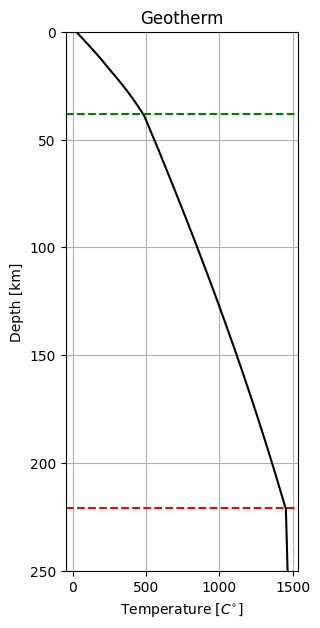

In [3]:
fig = plt.figure(figsize = (3,7))
ax = plt.subplot(111)
ax.plot(T-273.15,depth,color = 'k')
ax.axhline(moho,linestyle = '--', color = 'g')
ax.axhline(depth[idx_LAB],linestyle = '--', color = 'r')
ax.set_ylim(0,250.0)
ax.grid(which = 'both')
ax.set_xlabel(r'Temperature [$C^{\circ}$]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()
ax.set_title('Geotherm')
plt.show()


Now, let's calculate the electrical conductivity and seismic velocities that would result form this geotherm. We assume a simple lherzolitic matrix with 100 ppm bulk water content. The below cell will calculate the electrical conductivities. Once the compositional and thermodynamic environment set in the pide object, the conductivities can be calculate via **calculate_conductivity** method.

In [4]:
p_obj = pide.pide()

p_obj.set_temperature(T)
p_obj.set_pressure(p)

#Setting the composition
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.25,cpx = 0.1, garnet= 0.05)
#Setting water content in ppm
p_obj.set_bulk_water(100)
#Setting water partitioning models and distributing the water.
p_obj.set_mantle_water_partitions(opx_ol = 3, cpx_ol = 6, garnet_ol = 0)
p_obj.mantle_water_distribute()
#Electrical conductivity model choices for reach mineral
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 2, cpx = 4, gt = 4)
#Setting the phase mixing method to Lower Hashin-Shtrikman Bound
p_obj.set_solid_phs_mix_method(method = 1)
#Finally calculating the conductivity.
cond = p_obj.calculate_conductivity()

In pide, the seismic velocities can be calculated by simply running ***calculate_seismic_velocities*** method.

In [5]:
v_bulk, v_p, v_s = p_obj.calculate_seismic_velocities()

Now, let's plot them all together... We will plot electrical resistivity (1/electrical conductivity) since it is the general convention in magnetotelluric studies instead of plotting the conductivity. 

Text(0.5, 1.0, 'Seismic Velocities')

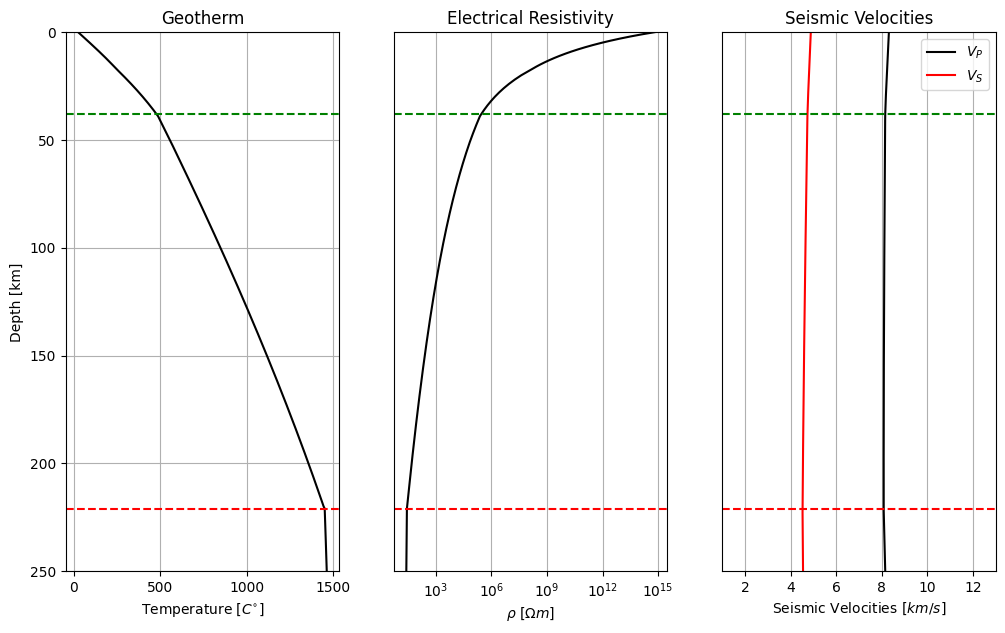

In [6]:
fig = plt.figure(figsize = (12,7))
ax = plt.subplot(131)
ax.plot(T-273.15,depth,color = 'k')
ax.axhline(moho,linestyle = '--', color = 'g')
ax.axhline(depth[idx_LAB],linestyle = '--', color = 'r')
ax.set_ylim(0,250.0)
ax.grid(which = 'both')
ax.set_xlabel(r'Temperature [$C^{\circ}$]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()
ax.set_title('Geotherm')

#Plotting the electrical resistivity profile.
ax2 = plt.subplot(132)
ax2.plot(1./cond,depth,color = 'k')
ax2.axhline(moho,linestyle = '--', color = 'g')
ax2.axhline(depth[idx_LAB],linestyle = '--', color = 'r')
ax2.set_ylim(0,250.0)
ax2.set_xscale('log')
ax2.grid(which = 'both')
ax2.set_xlabel(r'$\rho$ [$\Omega m$] ')
ax2.set_yticks([])
ax2.invert_yaxis()
ax2.set_title('Electrical Resistivity')

#plotting the seismic velocities

ax3 = plt.subplot(133)
ax3.plot(v_p,depth,color = 'k', label = r'$V_P$')
ax3.plot(v_s,depth,color = 'r', label = r'$V_S$')
ax3.axhline(moho,linestyle = '--', color = 'g')
ax3.axhline(depth[idx_LAB],linestyle = '--', color = 'r')
ax3.set_ylim(0,250.0)
ax3.set_xlim(1,13)
ax3.grid(which = 'both')
ax3.set_xlabel(r'Seismic Velocities [$km/s$]')
ax3.set_yticks([])
ax3.invert_yaxis()
ax3.legend()
ax3.set_title('Seismic Velocities')



Now, let's do the same with assuming different compositional layers along the geotherm. We can do this by first creating materials. Here, we need to import material and model objects. The material objects can be used to set up a calculation environment. After creating the materials, these can be put into a model object alongside with temperature and pressure.

In [7]:
from pide.material import Material
from pide.model import Model

#Here, other than the compositional and geometrical parameters, the user should also indicate the top and the bottom of the layers in km.
Layer_1_Upper_Crust = Material(name = 'Layer_1_Upper_Crust', calculation_type = 'rock', composition = {'granite':1.0},
                               el_cond_selections = {'granite': 10},solid_phase_mixing_idx = 1,top = 0, bottom = 15)

#Instead of using 15, the user here can also use another objects bottom variable.
Layer_2_Lower_Crust = Material(name = 'Layer_2_Lower_Crust', calculation_type = 'rock', composition = {'granulite':1.0},
                               el_cond_selections = {'granulite': 2},solid_phase_mixing_idx = 1,top = Layer_1_Upper_Crust.bottom, bottom = 38)

Layer_3_Upper_Mantle = Material(name = 'Layer_3_Upper_Mantle', calculation_type = 'mineral',
                                composition = {'ol':0.65,'opx':0.25,'garnet':0.05,'cpx':0.05},
                                solid_phase_mixing_idx = 1,
                                el_cond_selections = {'ol':4, 'opx':0, 'garnet':0,'cpx':0},
                                water_distr = True, water = {'bulk':0}, xfe = {'ol':0.1,'opx':0.1,'garnet':0.1, 'cpx':0.1},
                                top = Layer_2_Lower_Crust.bottom, bottom = 75)

#A layer's attributes can also be copied by the copy_attributes method in a material object:
Layer_4_Upper_Mantle = Material()
Layer_3_Upper_Mantle.copy_attributes(Layer_4_Upper_Mantle)
#Now change just only the water content and layer position from Layer_3
Layer_4_Upper_Mantle.water = {'bulk':200}
Layer_4_Upper_Mantle.top = Layer_3_Upper_Mantle.bottom
Layer_4_Upper_Mantle.bottom = 150

#Defining Layer_5 through layer 4 but changing the position and adding 5% phlogopites (mica) to the matrix.
Layer_5_Upper_Mantle = Material()
Layer_4_Upper_Mantle.copy_attributes(Layer_5_Upper_Mantle)
Layer_5_Upper_Mantle.composition = {'ol':0.60,'opx':0.20,'garnet':0.05,'mica':0.1,'cpx':0.05}
Layer_5_Upper_Mantle.top = Layer_4_Upper_Mantle.bottom
Layer_5_Upper_Mantle.bottom = 250

#Now creating a model object to put these layers in alongside with our thermodynamic conditions (T,P,Depth)
Layers = Model(material_list = [Layer_1_Upper_Crust,Layer_2_Lower_Crust,Layer_3_Upper_Mantle,Layer_4_Upper_Mantle,Layer_5_Upper_Mantle],
               T = T, P = p, depth = depth)




After Layers model object is set, this could be used to perform specific **calculate_geothermal_block** method. There are two types of this method, where user either choose to calculate conductivity or seismic velocities:

In [8]:
cond = Layers.calculate_geothermal_block(type = 'conductivity')
v_bulk,v_p,v_s = Layers.calculate_geothermal_block(type = 'seismic')

Now, let's plot these by running similar plotting code as before.

Text(0.5, 1.0, 'Seismic Velocities')

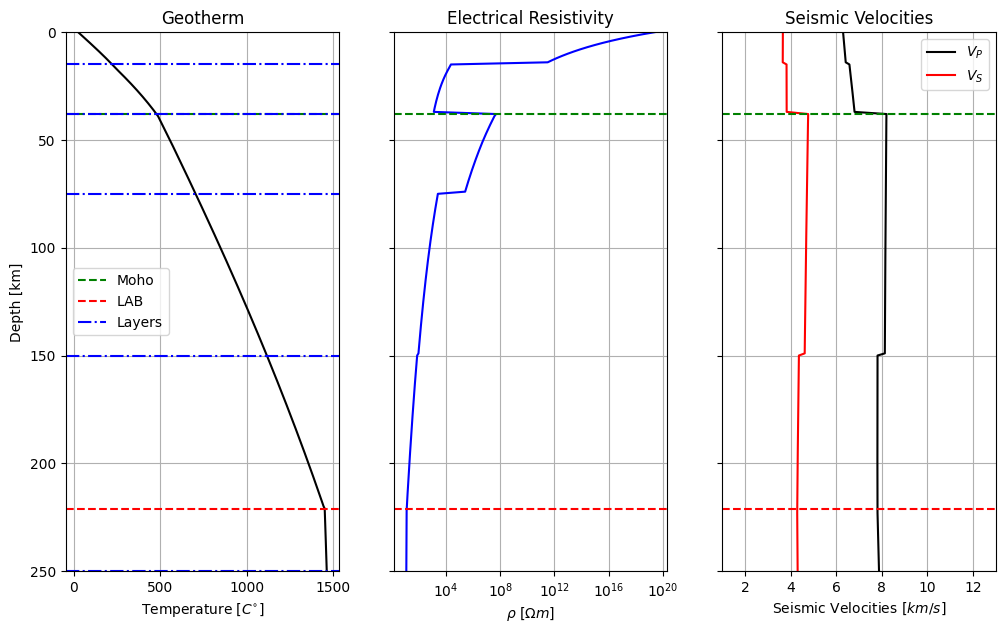

In [9]:
fig = plt.figure(figsize = (12,7))
ax = plt.subplot(131)
ax.plot(T-273.15,depth,color = 'k')
ax.axhline(moho,linestyle = '--', color = 'g',label = 'Moho')
ax.axhline(depth[idx_LAB],linestyle = '--', color = 'r',label = 'LAB')
ax.set_ylim(0,250.0)
ax.grid(which = 'both')
ax.set_xlabel(r'Temperature [$C^{\circ}$]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()
ax.set_title('Geotherm')

ax.axhline(Layer_1_Upper_Crust.bottom,linestyle = '-.',color = 'b', label = 'Layers')
ax.axhline(Layer_2_Lower_Crust.bottom,linestyle ='-.',color = 'b')
ax.axhline(Layer_3_Upper_Mantle.bottom,linestyle ='-.',color = 'b')
ax.axhline(Layer_4_Upper_Mantle.bottom,linestyle ='-.',color = 'b')
ax.axhline(Layer_5_Upper_Mantle.bottom,linestyle ='-.',color = 'b')
ax.legend()


#Plotting the electrical resistivity profile.
ax2 = plt.subplot(132)
ax2.plot(1./cond,depth,color = 'b')
ax2.axhline(moho,linestyle = '--', color = 'g')
ax2.axhline(depth[idx_LAB],linestyle = '--', color = 'r')
ax2.set_ylim(0,250.0)
ax2.set_xscale('log')
ax2.grid(which = 'both')
ax2.set_xlabel(r'$\rho$ [$\Omega m$] ')
ax2.set_yticklabels([])
ax2.invert_yaxis()
ax2.set_title('Electrical Resistivity')

#plotting the seismic velocities

ax3 = plt.subplot(133)
ax3.plot(v_p,depth,color = 'k', label = r'$V_P$')
ax3.plot(v_s,depth,color = 'r', label = r'$V_S$')
ax3.axhline(moho,linestyle = '--', color = 'g')
ax3.axhline(depth[idx_LAB],linestyle = '--', color = 'r')
ax3.set_ylim(0,250.0)
ax3.set_xlim(1,13)
ax3.grid(which = 'both')
ax3.set_xlabel(r'Seismic Velocities [$km/s$]')
ax3.set_yticklabels([])
ax3.invert_yaxis()
ax3.legend()
ax3.set_title('Seismic Velocities')
